In [4]:
from pyrl.agents.classic import A2CAgent
from pyrl.agents.survival import SurvivalA2CAgent
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

from tensorforce.agents import Agent
from tensorforce.environments import Environment
from pyrl.environments import CustomEnvironment
from tensorforce.execution import Runner

from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from tensorforce.agents import Agent as TFAgent
from tensorforce.core.networks import AutoNetwork


In [5]:
map_size = (50, 5)
horizon = 5000
points = 6
repeat = 3
survival_threshold = 250
exploration_threshold = 500
gamma = 0.99 # discount factor
initial_budgets = np.linspace(100, horizon, points, dtype=int)

batch_size = 32
exploration_rate = 0.9
learning_rate = 0.001
update_frequency = 1.0

In [6]:
env = Environment.create(
    environment=CustomEnvironment(render_mode="human", size=map_size),
    max_episode_timesteps=horizon
)

survival_dqn_time_mean = np.full(initial_budgets.shape, -1)
survival_dqn_exploration_rate = np.full(initial_budgets.shape, -1)
survival_dqn_alive_rate = np.full(initial_budgets.shape, -1)
survival_dqn_budget_evolutions = list()

survival_dqn_budget_evolutions_mean = np.full(initial_budgets.shape, None)
survival_dqn_budget_evolutions_max = np.full(initial_budgets.shape, None)
survival_dqn_budget_evolutions_min = np.full(initial_budgets.shape, None)


observation_space = env.states
action_space = env.actions()

for i, b in enumerate(initial_budgets):
    nb_alive = 0
    for j in range(repeat):
        print(f"====> Survival A2C {b} | Try {j + 1}")
        states = env.reset()
        
        agent = SurvivalA2CAgent(environment=env,
                         initial_observation=states,
                         batch_size=batch_size,
                         initial_budget=b,
                         horizon=horizon,
                         exploration=exploration_rate,
                         discount=gamma,
                         update_frequency=update_frequency,
                         learning_rate=learning_rate,
                        )
        
        agent.reset(states)
        exploration_matrix = np.zeros((env.observation_space.n, env.action_space.n))
        budget_evolution = np.zeros((horizon,), dtype=int)
        
        for t in count():
            actions = agent.act(states=states)
            states, terminated, reward= env.execute(actions=actions)
            done = terminated or t >= horizon or agent.b <= 0
            exploration_matrix[int(states), int(actions)] = exploration_matrix[int(states), int(actions)] + 1
            agent.observe(states, reward, terminated=terminated)            
            env.render()
            
            budget_evolution[t-1] = agent.b

            if done:
                print("t = ", t)
                if survival_dqn_time_mean[i] == -1:
                    survival_dqn_time_mean[i] = t
                else:
                    survival_dqn_time_mean[i] = survival_dqn_time_mean[i] + (1/(j+1)) * (t - survival_dqn_time_mean[i])
                break
        
        
        exploration_rate = (np.count_nonzero(exploration_matrix) / (env.observation_space.n * env.action_space.n)) * 100

        if survival_dqn_exploration_rate[i] == -1:
            survival_dqn_exploration_rate[i] = exploration_rate
        else:
            survival_dqn_exploration_rate[i] = survival_dqn_exploration_rate[i] + (1 / (j+1)) * (exploration_rate - survival_dqn_exploration_rate[i])

        if agent.b > 0:
            nb_alive = nb_alive + 1

        survival_dqn_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if survival_dqn_budget_evolutions_mean[i] is None:
            survival_dqn_budget_evolutions_mean[i] = budget_evolution
        else:
            survival_dqn_budget_evolutions_mean[i] = survival_dqn_budget_evolutions_mean[i] + (1 / (j+1)) * (budget_evolution - survival_dqn_budget_evolutions_mean[i])

        # budget evolution max
        if survival_dqn_budget_evolutions_max[i] is None:
            survival_dqn_budget_evolutions_max[i] = budget_evolution
        else:
            survival_dqn_budget_evolutions_max[i] = np.maximum(survival_dqn_budget_evolutions_max[i], budget_evolution)

        # budget evolution min
        if survival_dqn_budget_evolutions_min[i] is None:
            survival_dqn_budget_evolutions_min[i] = budget_evolution
        else:
            survival_dqn_budget_evolutions_min[i] = np.minimum(survival_dqn_budget_evolutions_min[i], budget_evolution)
        
        print(f"Time mean : {survival_dqn_time_mean[i]}")
        print(f"Alive rate : {survival_dqn_alive_rate[i]}%")
        print(f"Exploration rate: {survival_dqn_exploration_rate[i]}%")

====> Survival A2C 100 | Try 1
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 6%
====> Survival A2C 100 | Try 2
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 5%
====> Survival A2C 100 | Try 3
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 4%
====> Survival A2C 1080 | Try 1
t =  1122
Time mean : 1122
Alive rate : 0%
Exploration rate: 43%
====> Survival A2C 1080 | Try 2
t =  1122
Time mean : 1122
Alive rate : 0%
Exploration rate: 47%
====> Survival A2C 1080 | Try 3
t =  1080
Time mean : 1108
Alive rate : 0%
Exploration rate: 37%
====> Survival A2C 2060 | Try 1
t =  2066
Time mean : 2066
Alive rate : 0%
Exploration rate: 44%
====> Survival A2C 2060 | Try 2
t =  2312
Time mean : 2189
Alive rate : 0%
Exploration rate: 52%
====> Survival A2C 2060 | Try 3
t =  2138
Time mean : 2172
Alive rate : 0%
Exploration rate: 48%
====> Survival A2C 3040 | Try 1
t =  4999
Time mean : 4999
Alive rate : 100%
Exploration rate: 86%
====> Survival A2C 3040 | Try 2
t =  361

In [7]:
env = Environment.create(
    environment=CustomEnvironment(render_mode="human", size=map_size),
    max_episode_timesteps=horizon,
)

dqn_time_mean = np.full(initial_budgets.shape, -1)
dqn_exploration_rate = np.full(initial_budgets.shape, -1)
dqn_alive_rate = np.full(initial_budgets.shape, -1)
dqn_budget_evolutions_mean = np.full(initial_budgets.shape, None)
dqn_budget_evolutions_max = np.full(initial_budgets.shape, None)
dqn_budget_evolutions_min = np.full(initial_budgets.shape, None)


observation_space = env.states
action_space = env.actions()

for i, b in enumerate(initial_budgets):
    nb_alive = 0
    for j in range(repeat):
        print(f"====> Classic A2C {b} | Try {j + 1}")
        states = env.reset()
        
        agent = A2CAgent(environment=env,
                         initial_observation=states,
                         batch_size=batch_size,
                         initial_budget=b,
                         horizon=horizon,
                         exploration=exploration_rate,
                         discount=gamma,
                         update_frequency=update_frequency,
                         learning_rate=learning_rate,
                        )
                         
        agent.reset(states)
        exploration_matrix = np.zeros((env.observation_space.n, env.action_space.n))
        budget_evolution = np.zeros((horizon,), dtype=int)
        
        for t in count():
            actions = agent.act(states=states)
            states, terminated, reward = env.execute(actions=actions)
            done = terminated or t >= horizon or agent.b <= 0
            exploration_matrix[int(states), int(actions)] = exploration_matrix[int(states), int(actions)] + 1
            agent.observe(states, reward, terminated=terminated)
            env.render()
            
            budget_evolution[t-1] = agent.b
            
            if done:
                print("t = ", t)
                if dqn_time_mean[i] == -1:
                    dqn_time_mean[i] = t
                else:
                    dqn_time_mean[i] = dqn_time_mean[i] + (1/(j+1)) * (t - dqn_time_mean[i])
                
                break
        
        exploration_rate = (np.count_nonzero(exploration_matrix) / (env.observation_space.n * env.action_space.n)) * 100

        if dqn_exploration_rate[i] == -1:
            dqn_exploration_rate[i] = exploration_rate
        else:
            dqn_exploration_rate[i] = dqn_exploration_rate[i] + (1/(j+1)) * (exploration_rate - dqn_exploration_rate[i])

        if agent.b > 0:
            nb_alive = nb_alive + 1

        dqn_alive_rate[i] = nb_alive / (j+1) * 100
        
         # budget evolution mean
        if dqn_budget_evolutions_mean[i] is None:
            dqn_budget_evolutions_mean[i] = budget_evolution
        else:
            dqn_budget_evolutions_mean[i] = dqn_budget_evolutions_mean[i] + (1/(j+1)) * (budget_evolution - dqn_budget_evolutions_mean[i])

        # budget evolution max
        if dqn_budget_evolutions_max[i] is None:
            dqn_budget_evolutions_max[i] = budget_evolution
        else:
            dqn_budget_evolutions_max[i] = np.maximum(dqn_budget_evolutions_max[i], budget_evolution)

        # budget evolution min
        if dqn_budget_evolutions_min[i] is None:
            dqn_budget_evolutions_min[i] = budget_evolution
        else:
            dqn_budget_evolutions_min[i] = np.minimum(dqn_budget_evolutions_min[i], budget_evolution)
        

        print(f"Time mean : {dqn_time_mean[i]}")
        print(f"Alive rate : {dqn_alive_rate[i]}%")
        print(f"Exploration rate: {dqn_exploration_rate[i]}%")

====> Classic A2C 100 | Try 1
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 5%
====> Classic A2C 100 | Try 2
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 5%
====> Classic A2C 100 | Try 3
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 4%
====> Classic A2C 1080 | Try 1
t =  1599
Time mean : 1599
Alive rate : 0%
Exploration rate: 58%
====> Classic A2C 1080 | Try 2
t =  1104
Time mean : 1351
Alive rate : 0%
Exploration rate: 44%
====> Classic A2C 1080 | Try 3
t =  1104
Time mean : 1268
Alive rate : 0%
Exploration rate: 38%
====> Classic A2C 2060 | Try 1
t =  2114
Time mean : 2114
Alive rate : 0%
Exploration rate: 32%
====> Classic A2C 2060 | Try 2
t =  3590
Time mean : 2852
Alive rate : 0%
Exploration rate: 55%
====> Classic A2C 2060 | Try 3
t =  2126
Time mean : 2610
Alive rate : 0%
Exploration rate: 47%
====> Classic A2C 3040 | Try 1
t =  4729
Time mean : 4729
Alive rate : 0%
Exploration rate: 86%
====> Classic A2C 3040 | Try 2
t =  3088
Time mean :

## Results

### Survival time

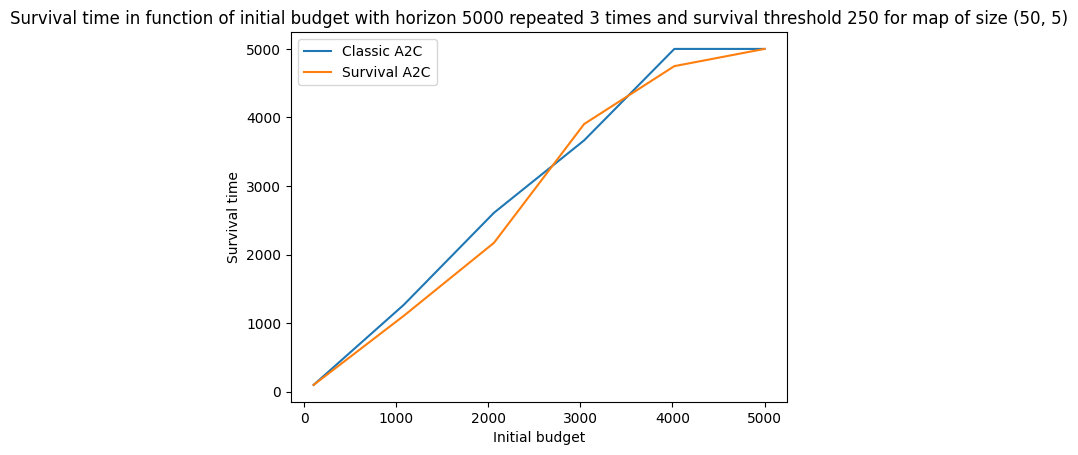

In [8]:
plt.plot(initial_budgets, dqn_time_mean, label="Classic A2C")
plt.plot(initial_budgets, survival_dqn_time_mean, label="Survival A2C")
plt.xlabel("Initial budget")
plt.ylabel("Survival time")
plt.legend()
plt.title(f"Survival time in function of initial budget with horizon {horizon} repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

### Alive rate

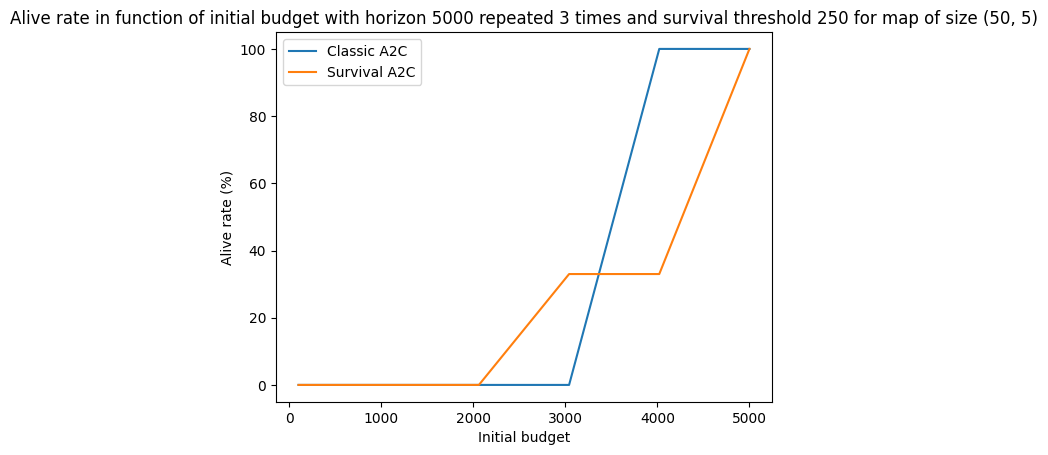

In [9]:
plt.plot(initial_budgets, dqn_alive_rate, label="Classic A2C")
plt.plot(initial_budgets, survival_dqn_alive_rate, label="Survival A2C")
plt.xlabel("Initial budget")
plt.ylabel("Alive rate (%)")
plt.legend()
plt.title(f"Alive rate in function of initial budget with horizon {horizon} repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

### Exploration rate

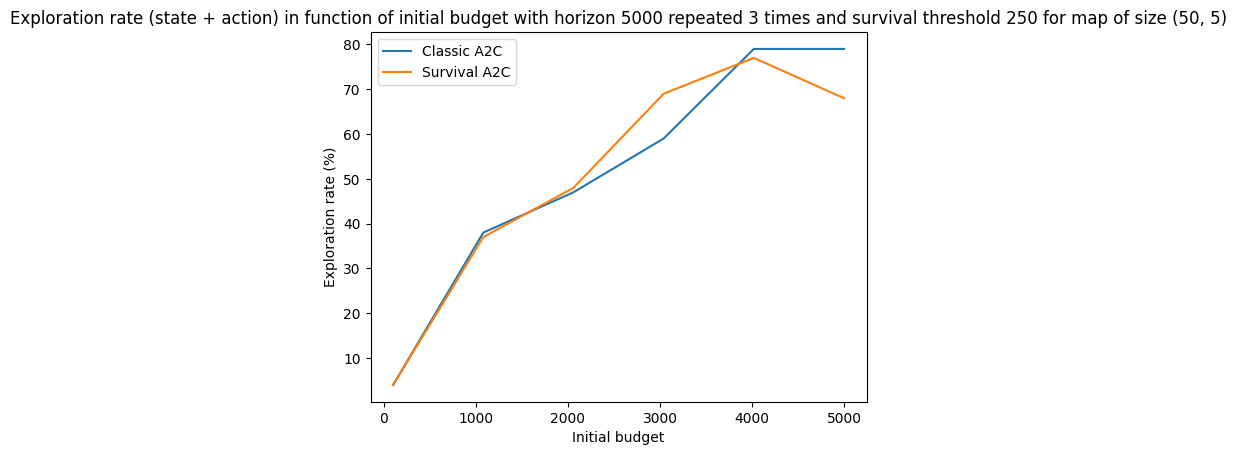

In [10]:
plt.plot(initial_budgets, dqn_exploration_rate, label="Classic A2C")
plt.plot(initial_budgets, survival_dqn_exploration_rate, label="Survival A2C")
plt.xlabel("Initial budget")
plt.ylabel("Exploration rate (%)")
plt.legend()
plt.title(f"Exploration rate (state + action) in function of initial budget with horizon {horizon} repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

### Budget evolution

In [11]:
print("Available budgets :")
print(initial_budgets)

Available budgets :
[ 100 1080 2060 3040 4020 5000]


In [12]:
plt.rcParams["figure.figsize"] = (10,10)

with_bounds = False

show_only = []

#### Classic DQN

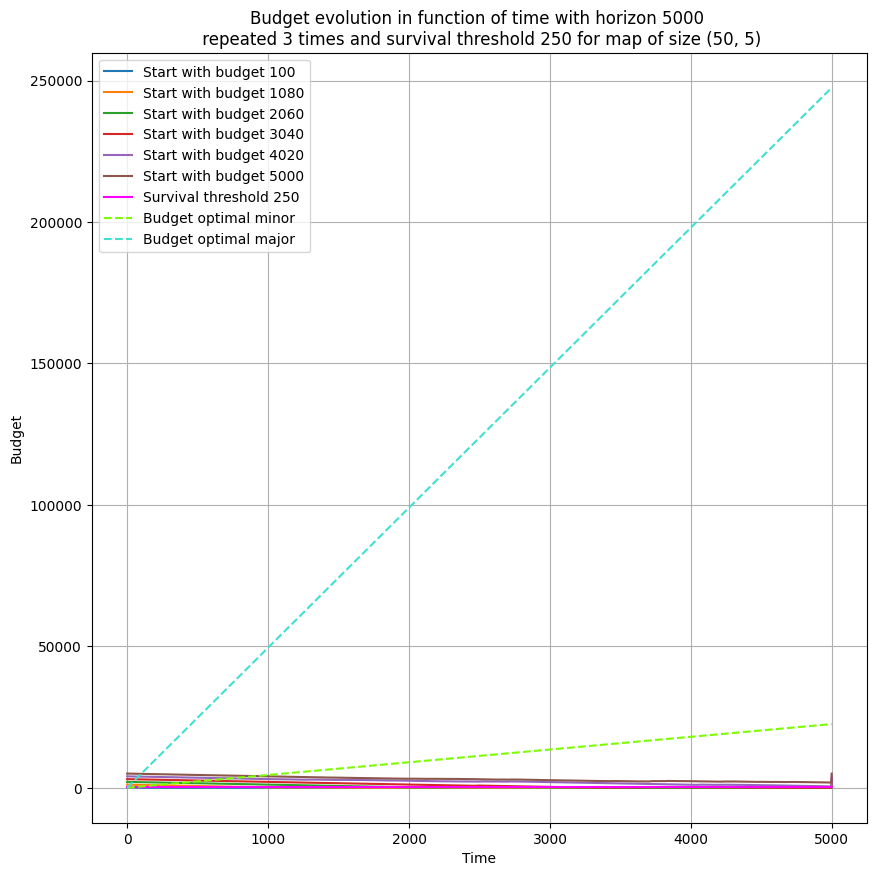

In [13]:
t = np.arange(horizon)

for i, evo in enumerate(dqn_budget_evolutions_mean):
    if len(show_only) > 0 and initial_budgets[i] not in show_only:
        continue
    
    lines = plt.plot(t, evo, label=f"Start with budget {initial_budgets[i]}")

    if with_bounds:
        plt.fill_between(t, dqn_budget_evolutions_min[i], dqn_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

plt.plot(t, np.full((horizon,), survival_threshold), color="magenta", label=f"Survival threshold {survival_threshold}")
plt.plot(t, 4.5 * t, color="lawngreen", ls="--", label=f"Budget optimal minor")
plt.plot(t, 49.5 * t, color="turquoise", ls="--", label=f"Budget optimal major")
plt.xlabel("Time")
plt.ylabel("Budget")
plt.legend()
plt.grid()
plt.title(f"Budget evolution in function of time with horizon {horizon} \n repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

#### Survival DQN

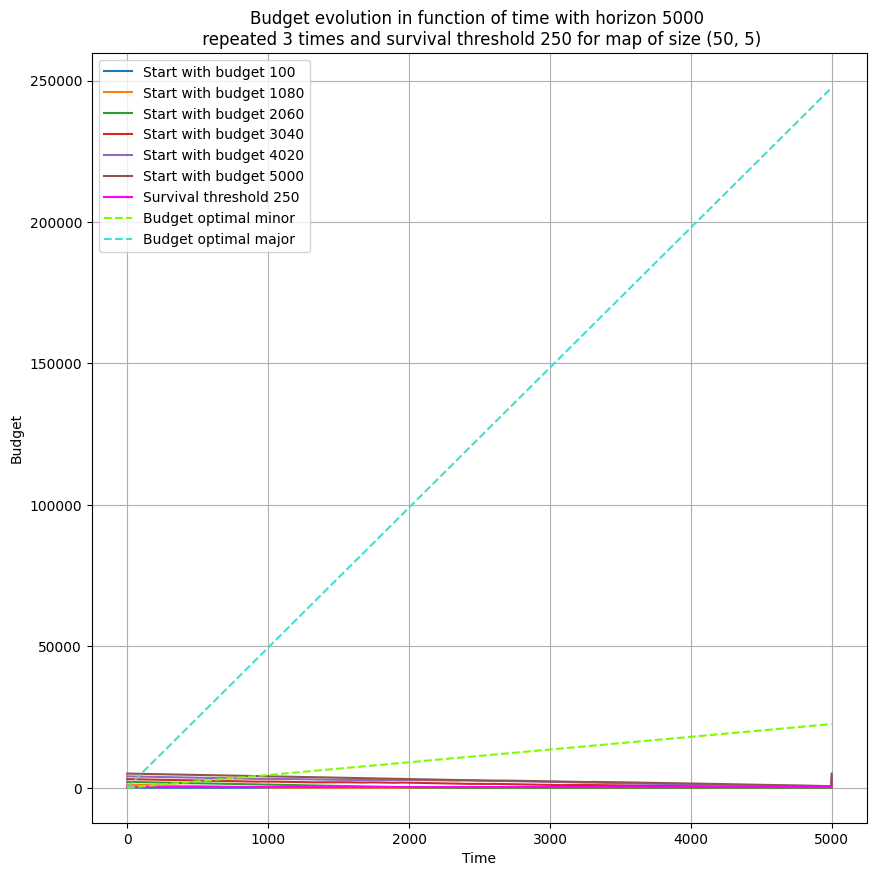

In [14]:
import matplotlib.colors as mcolors

t = np.arange(horizon)

for i, evo in enumerate(survival_dqn_budget_evolutions_mean):
    if len(show_only) > 0 and initial_budgets[i] not in show_only:
        continue
    
    lines = plt.plot(t, evo, label=f"Start with budget {initial_budgets[i]}")

    if with_bounds:
        plt.fill_between(t, survival_dqn_budget_evolutions_min[i], survival_dqn_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

plt.plot(t, np.full((horizon,), survival_threshold), color="magenta", label=f"Survival threshold {survival_threshold}")
plt.plot(t, 4.5 * t, color="lawngreen", ls="--", label=f"Budget optimal minor")
plt.plot(t, 49.5 * t, color="turquoise", ls="--", label=f"Budget optimal major")
plt.xlabel("Time")
plt.ylabel("Budget")
plt.legend()
plt.grid()
plt.title(f"Budget evolution in function of time with horizon {horizon} \n repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()